# Kidney Images
Erin De Pree

Images are from hospitals in Dhaka, Bangladesh.  12,446 CT scans, with and without contrast.  4 classification groups: normal, tumor, cyst, stone.
Image size varies.

Data Source (1.66 GB)
* [Kaggle link](https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone)
* Article: Islam, M.N., Hasan, M., Hossain, M.K. et al. Vision transformer and explainable transfer learning models for auto detection of kidney cyst, stone and tumor from CT-radiography. Sci Rep 12, 11440 (2022). [https://doi.org/10.1038/s41598-022-15634-4](https://doi.org/10.1038/s41598-022-15634-4).  [Link to article](https://www.nature.com/articles/s41598-022-15634-4)

In [119]:
import pandas as pd
import numpy as np
# import kagglehub # only needed to download data
import matplotlib.pyplot as plt

import keras
from keras import layers, ops

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [120]:
def report_scores(y_true, y_pred, model_label):
    print(model_label)
    print()
    print('Classification report:')
    print(classification_report(y_true, y_pred, target_names=['cyst', 'normal', 'stone', 'tumor'], digits=3))

## Import Data

This is a VERY large data set (1.5 GB when zipped).

In [2]:
# path = kagglehub.dataset_download("nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone")

# print("Path to dataset files:", path)

100%|██████████████████████████████████████| 1.52G/1.52G [14:04<00:00, 1.93MB/s]

Extracting files...


Path to dataset files: /Users/erindepree/.cache/kagglehub/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone/versions/1


In [2]:
# .csv file with summary classifications
df = pd.read_csv('../data/kidneyData.csv').drop(columns=['Unnamed: 0'])

In [3]:
df.head()

,image_id,path,diag,target,Class
0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12446 entries, 0 to 12445
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  12446 non-null  object
 1   path      12446 non-null  object
 2   diag      12446 non-null  object
 3   target    12446 non-null  int64 
 4   Class     12446 non-null  object
dtypes: int64(1), object(4)
memory usage: 486.3+ KB


No missing data.

In [6]:
df['diag'].value_counts(normalize=True)

diag
Normal    0.407922
Cyst      0.298007
Tumor     0.183432
Stone     0.110638
Name: proportion, dtype: float64

In [7]:
df['target'].value_counts(normalize=True)

target
1    0.407922
0    0.298007
3    0.183432
2    0.110638
Name: proportion, dtype: float64

In [4]:
df['Class'].value_counts()

Class
Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: count, dtype: int64

Class Structures
| Class | integer |  |
| --- | :---: | :---: |
| Cyst | 0 | $29.8\%$ |
| Normal | 1 | $40.8\%$ |
| Stone | 2 | $11.1\%$ |
| Tumor | 3 | $18.3\%$ |

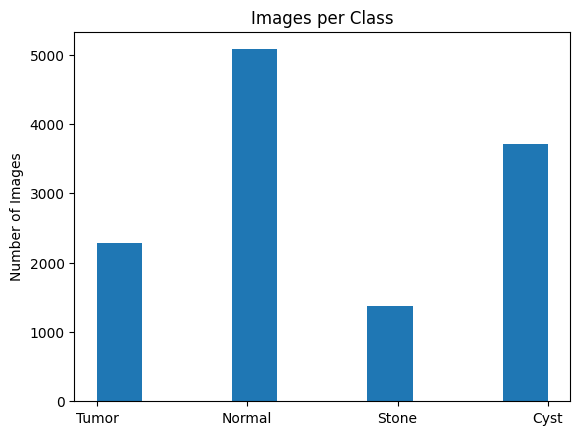

In [14]:
# histogram of classes

fig, ax = plt.subplots()

ax.hist(df['Class'])
ax.set_title('Images per Class')

ax.set_ylabel('Number of Images');

fig.savefig('../images/classes.jpg')

Happily, Keras uses the directory structure to figure out the labels!

In [29]:
# This is the code used to load ALL images (over 12,000)
dir_path = '../../../../DataSci/datasets/kidneys/images'

train_df, val_df = keras.utils.image_dataset_from_directory(
    dir_path,
    #labels = labels,
    validation_split = 0.2,
    subset = 'both',
    seed = 172372,
    image_size = (1250, 1250), # image size
    pad_to_aspect_ratio = True, # want same image size, but maintain aspect ratio by padding out images
    batch_size = 128,
    color_mode= 'grayscale'
)

Found 12446 files belonging to 4 classes.
Using 9957 files for training.
Using 2489 files for validation.


I have chosen to keep preprocessing images to a minimum as this is a really big data set and I'm already running out of time and had a few crashes already, so I'm avoiding the random rotations and such.  I'm also concerned about randomly rotating the images as taking advantage of the anatomy is important and the human body is not symmetric on reflection! 

I have resized images to the same size (as all images in a batch much be the same size).  And I will rescale from 255 to 1 as an initial step in my model.

In [6]:
# load sample images included in this repo.

sample_path = '../data/images_sample'

sample_df = keras.utils.image_dataset_from_directory(
    sample_path,
    image_size = (1250, 1250),
    pad_to_aspect_ratio=True,
    batch_size=128,
    color_mode= 'grayscale'
)

Found 84 files belonging to 4 classes.


Padding images out to same size so that they are all the same size while preserving the aspect ratio.

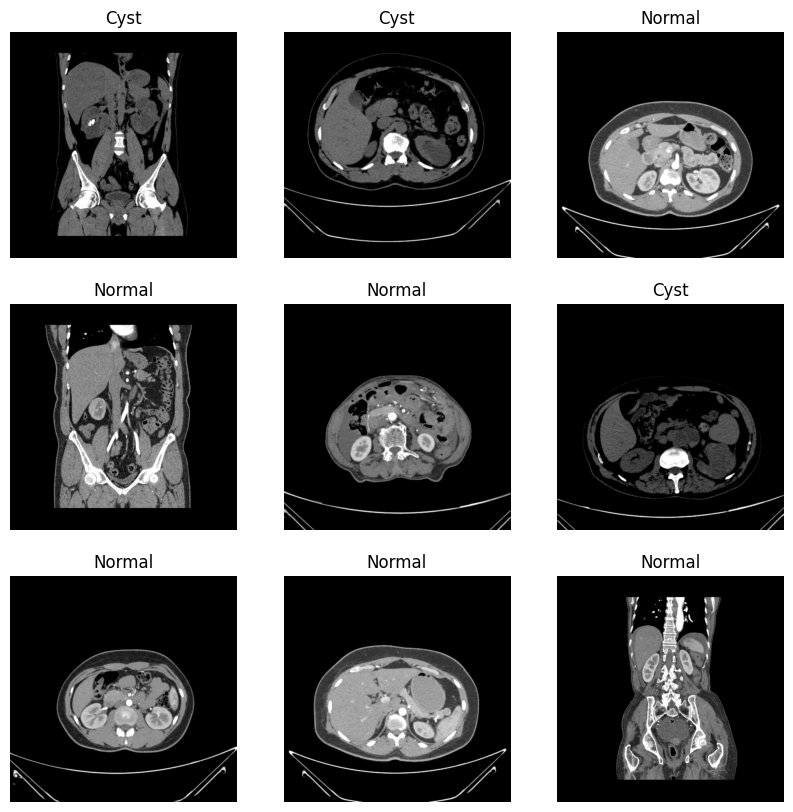

In [17]:
# 9 images
group = ['Cyst', 'Normal', 'Stone', 'Tumor']

fig = plt.figure(figsize=(10,10))

for images, labels in sample_df.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(np.array(images[i]), cmap='gray')
        plt.title(group[int(labels[i])])
        plt.axis('off')

fig.savefig('../images/examples.jpg')

## Naive Image Classification Model

This is my first classification model attempt. It rescales the input and then applies convolution and max pooling layers until output shape is (None, 4, 4, 32).  Then apply global max pooling.  Followed by some dense (or fully connected layers) and then a final softmax output layer to multiclasses.

In [22]:
model = keras.Sequential(
    [
        keras.Input(shape=(1250, 1250, 1)),
        layers.Rescaling(1.0 / 255),
        layers.Conv2D(32,5, strides=2, activation='relu'),
        layers.Conv2D(32,3, activation='relu'),
        layers.MaxPooling2D(3), # output shape was (415, 415, 32) keep downsampling
        layers.Conv2D(32,3, activation='relu'),
        layers.MaxPooling2D(3),
        layers.Conv2D(32,3, activation='relu'),
        layers.MaxPooling2D(3),
        layers.Conv2D(32,3, activation='relu'),
        layers.MaxPooling2D(5),
        layers.GlobalMaxPooling2D(),
        layers.Dense(10),
        layers.Dense(4),
        layers.Softmax()
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 1250, 1250, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 623, 623, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 621, 621, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 207, 207, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 205, 205, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 68, 68, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 66, 66, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 20, 20, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            44 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,198 (149.21 KB)

 Trainable params: 38,198 (149.21 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(
    optimizer = keras.optimizers.Adam(), # optimizer that performed best during the prior lab
    loss = keras.losses.SparseCategoricalCrossentropy(), # for integer encoded multi-classes
    metrics = [keras.metrics.SparseCategoricalAccuracy()] # for integer encoded multi-classes
)

In [7]:
# save best model during training
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = 'model_1_checkpoints/{epoch:02d}.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='max'
)

# conditions for early stopping
model_earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', # making decision on whether the loss of the validation data is changing or not
    patience= 2, # wait at least two epochs before stopping early
    baseline=0.001, # minimum change allowed
    start_from_epoch=5 # wait until after epoch 5 to check for early stopping
)

In [8]:
history_1 = model.fit(
    train_df,
    epochs = 20, # up to 20 training epochs
    validation_data = val_df,
    validation_freq = 2, # check every other epoch, I wish I had checked every epoch, would have been easier to plot
    callbacks= [model_checkpoint, model_earlystopping]
)

Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1711s 22s/step - loss: 1.1561 - sparse_categorical_accuracy: 0.5178
Epoch 2/20


/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,sparse_categorical_accuracy
  current = self.get_monitor_value(logs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 2070s 27s/step - loss: 0.4045 - sparse_categorical_accuracy: 0.8466 - val_loss: 0.2119 - val_sparse_categorical_accuracy: 0.9405
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2060s 26s/step - loss: 0.1594 - sparse_categorical_accuracy: 0.9518
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2064s 26s/step - loss: 0.0785 - sparse_categorical_accuracy: 0.9748 - val_loss: 0.0478 - val_sparse_categorical_accuracy: 0.9847
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2060s 26s/step - loss: 0.0615 - sparse_categorical_accuracy: 0.9783
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2116s 27s/step - loss: 0.0264 - sparse_categorical_accuracy: 0.9935 - val_loss: 0.5254 - val_sparse_categorical_accuracy: 0.8863
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1771s 23s/step - loss: 0.5398 - sparse_categorical_accuracy: 0.8668
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1789s 23s/step - loss: 0.0199 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.0110 - val_sparse_categorical_accuracy: 0.9984
Epoch 9/20
78/78 ━━━━━━━━

There's not a significant improvement after epoch 11 (if we're picky) and the best model is still the model from epoch 6.  So there was lots of unnecessary epochs because of poorly chosen stopping conditions and not testing the validation set every epoch.

These training loops took a total of about 10 hours on my computer.  

In [25]:
history1 = keras.models.load_model('model_1_checkpoints/06.keras')

In [31]:
preds1 = history1.predict(val_df)

20/20 ━━━━━━━━━━━━━━━━━━━━ 104s 5s/step


In [59]:
val_y_pred1 = np.argmax(preds1, axis=1)

In [46]:
val_y_true = np.concatenate([y for im, y in val_df])

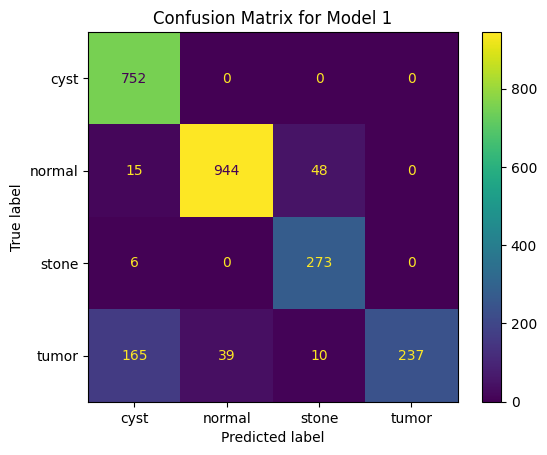

In [78]:
fig, ax = plt.subplots()

ConfusionMatrixDisplay.from_predictions(val_y_true, val_y_pred1, display_labels=['cyst', 'normal', 'stone', 'tumor'], ax=ax)
ax.set_title('Confusion Matrix for Model 1');

fig.savefig('../images/confusionmatrix_model1.png')

In [ ]:
# how did the training process go?
fig, ax = plt.subplots()

ax.plot(history1.history['sparse_categorical_accuracy'])
ax.plot(history1.history['loss'])

ax.set_title('Model 1: Metrics')
ax.set_xlabel('epochs')
#ax.set_ylabel('sparse categorical accuracy')
ax.legend(['sparse categorical accuracy', 'loss']);
#ax.plot(history_1.history['val_sparse_categorical_accuracy']);

plt.savefig('../images/model1.jpg')

In [53]:
history1 = pd.DataFrame([
    {'epoch': 1, 'loss': 1.5161, 'sparse_categorical_accuracy': 0.5178},
    {'epoch': 2, 'loss': 0.4045, 'sparse_categorical_accuracy': 0.8466, 'val_loss': 0.2119, 'val_sparse_categorical_accuracy': 0.9405},
    {'epoch': 3, 'loss': 0.1594, 'sparse_categorical_accuracy': 0.9518},
    {'epoch': 4, 'loss': 0.0785, 'sparse_categorical_accuracy': 0.9748, 'val_loss': 0.0478, 'val_sparse_categorical_accuracy': 0.9847},
    {'epoch': 5, 'loss': 0.0615, 'sparse_categorical_accuracy': 0.9783},
    {'epoch': 6, 'loss': 0.0264, 'sparse_categorical_accuracy': 0.9935, 'val_loss': 0.5254, 'val_sparse_categorical_accuracy': 0.8863},
    {'epoch': 7, 'loss': 0.5398, 'sparse_categorical_accuracy': 0.8668},
    {'epoch': 8, 'loss': 0.0199, 'sparse_categorical_accuracy': 0.9969, 'val_loss': 0.110, 'val_sparse_categorical_accuracy': 0.9984},
    {'epoch': 9, 'loss': 0.0065, 'sparse_categorical_accuracy': 0.9997},
    {'epoch': 10, 'loss': 0.0036, 'sparse_categorical_accuracy': 0.9999, 'val_loss': 0.0036, 'val_sparse_categorical_accuracy': 0.9996},
    {'epoch': 11, 'loss': 0.0017, 'sparse_categorical_accuracy': 1.0000},
    {'epoch': 12, 'loss': 0.0011, 'sparse_categorical_accuracy': 1.0000, 'val_loss': 0.0026, 'val_sparse_categorical_accuracy': 0.9996},
    {'epoch': 13, 'loss': 0.000753, 'sparse_categorical_accuracy': 1.0000},
    {'epoch': 14, 'loss': 0.000525, 'sparse_categorical_accuracy': 1.0000, 'val_loss': 0.0022, 'val_sparse_categorical_accuracy': 0.9996},
    {'epoch': 15, 'loss': 0.000421, 'sparse_categorical_accuracy': 1.0000},
    {'epoch': 16, 'loss': 0.000310, 'sparse_categorical_accuracy': 1.0000, 'val_loss': 0.0018, 'val_sparse_categorical_accuracy': 0.9996},
    {'epoch': 17, 'loss': 0.000238, 'sparse_categorical_accuracy': 1.0000},
    {'epoch': 18, 'loss': 0.000201, 'sparse_categorical_accuracy': 1.0000, 'val_loss': 0.0021, 'val_sparse_categorical_accuracy': 0.9992}
])

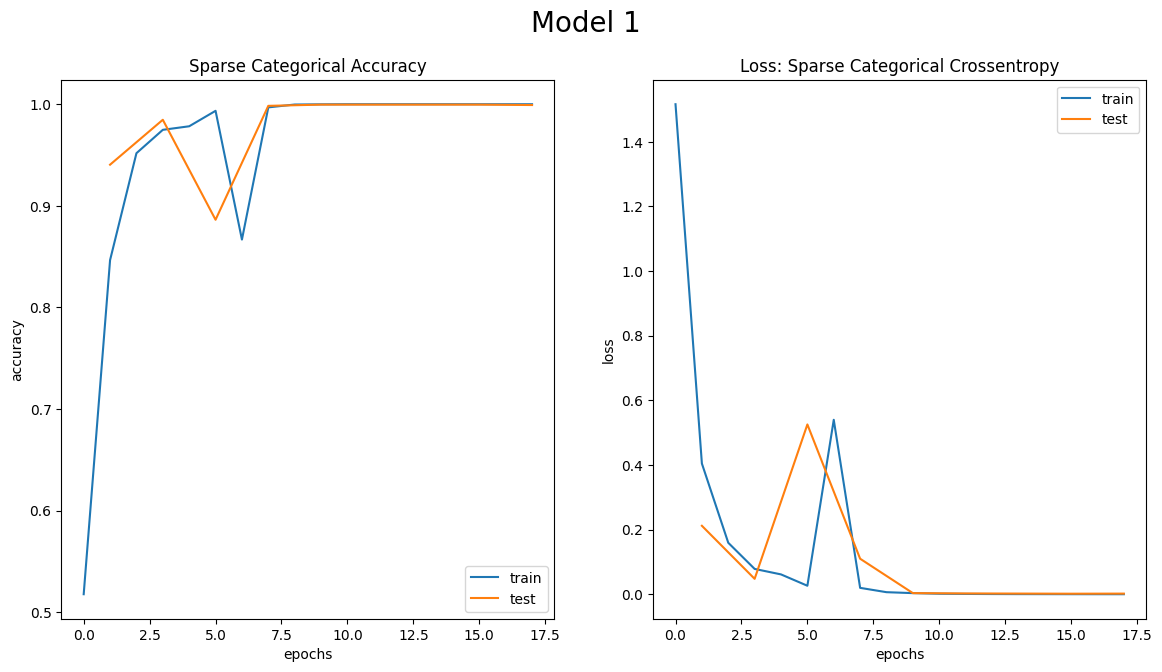

In [56]:
# how did the training process go?
fig, axes = plt.subplots(1,2, figsize=(14,7))

fig.suptitle('Model 1', fontsize = 20)
ax = axes[0]
ax.plot(history1['sparse_categorical_accuracy'], label='train')
ax.plot(history1['val_sparse_categorical_accuracy'].dropna(), label='test')

ax.set_title('Sparse Categorical Accuracy')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')
ax.legend()

ax = axes[1]
ax.plot(history1['loss'], label='train')
ax.plot(history1['val_loss'].dropna(), label='test')
ax.set_title('Loss: Sparse Categorical Crossentropy')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend();

plt.savefig('../images/model1.jpg')

I ran many more epochs than was necessary by choosing the wrong early stopping value (way too small).  I also wish I had calculated the validation metrics every epoch for easier plotting.

In [48]:
report_scores(val_y_true, val_y_pred1, 'Model 1')

Model 1

Accuracy score: 0.8862997187625552

Classification report:
              precision    recall  f1-score   support

        cyst      0.802     1.000     0.890       752
      normal      0.960     0.937     0.949      1007
       stone      0.825     0.978     0.895       279
       tumor      1.000     0.525     0.689       451

    accuracy                          0.886      2489
   macro avg      0.897     0.860     0.856      2489
weighted avg      0.904     0.886     0.878      2489



## Model 2: More Dense Layers at the End

In a prior lab, I saw that increasing the number of layers ran faster and improved performance more than adding more nodes to each layer.  So, my first improvement is to add more dense layers to the end of my model.

In [39]:
model2 = keras.Sequential(
    [
        keras.Input(shape=(1250, 1250, 1)),
        layers.Rescaling(1.0 / 255),
        layers.Conv2D(32,5, strides=2, activation='relu'),
        layers.Conv2D(32,3, activation='relu'),
        layers.MaxPooling2D(3), # output shape was (415, 415, 32) keep downsampling
        layers.Conv2D(32,3, activation='relu'),
        layers.MaxPooling2D(3),
        layers.Conv2D(32,3, activation='relu'),
        layers.MaxPooling2D(3),
        layers.Conv2D(32,3, activation='relu'),
        layers.MaxPooling2D(5),
        layers.GlobalMaxPooling2D(),
        layers.Dense(32),
        layers.Dense(16),
        layers.Dense(8),
        layers.Dense(4),
        layers.Softmax()
    ]
)

model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 1250, 1250, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 623, 623, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 621, 621, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 207, 207, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 205, 205, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 68, 68, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 66, 66, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 20, 20, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_5          │ (None, 32)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_5 (Softmax)             │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,580 (154.61 KB)

 Trainable params: 39,580 (154.61 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model2.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [
        keras.metrics.SparseCategoricalAccuracy(), 
        keras.metrics.SparseCategoricalCrossentropy()
    ]
)

I decided to add cross-entropy to my metrics and figured out later that I can already see the cross-entropy via the loss function.  Oh well.  I'll leave it out of the metrics in future models.

In [42]:
# to make sure I have a back up of the best model so far, just in case of crashes and such.
model2_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = 'model_2_checkpoints/{epoch:02d}.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='max'
)

model2_earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience= 2,
    baseline=0.01,
    start_from_epoch=4
)

In [43]:
history_2 = model2.fit(
    train_df,
    epochs = 20,
    validation_data = val_df,
    validation_freq = 1,
    callbacks= [model2_checkpoint, model2_earlystopping]
)

Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2266s 29s/step - loss: 1.1836 - sparse_categorical_accuracy: 0.4936 - sparse_categorical_crossentropy: 1.1836 - val_loss: 0.5672 - val_sparse_categorical_accuracy: 0.7887 - val_sparse_categorical_crossentropy: 0.5672
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1893s 24s/step - loss: 0.4172 - sparse_categorical_accuracy: 0.8465 - sparse_categorical_crossentropy: 0.4172 - val_loss: 0.2386 - val_sparse_categorical_accuracy: 0.9160 - val_sparse_categorical_crossentropy: 0.2386
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1722s 22s/step - loss: 0.1689 - sparse_categorical_accuracy: 0.9479 - sparse_categorical_crossentropy: 0.1689 - val_loss: 0.1117 - val_sparse_categorical_accuracy: 0.9642 - val_sparse_categorical_crossentropy: 0.1117
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1716s 22s/step - loss: 0.1073 - sparse_categorical_accuracy: 0.9616 - sparse_categorical_crossentropy: 0.1073 - val_loss: 0.0515 - val_sparse_categorical_accuracy: 0.9835 - val_sparse_categorical_c

In [45]:
with open('model2.pkl', 'wb') as f:
    pickle.dump(history_2, f)

In [47]:
history_2.history['sparse_categorical_accuracy']

[0.6065079569816589,
 0.8777744174003601,
 0.9553078413009644,
 0.9654514193534851,
 0.9931706190109253,
 0.9972883462905884,
 0.9934719204902649]

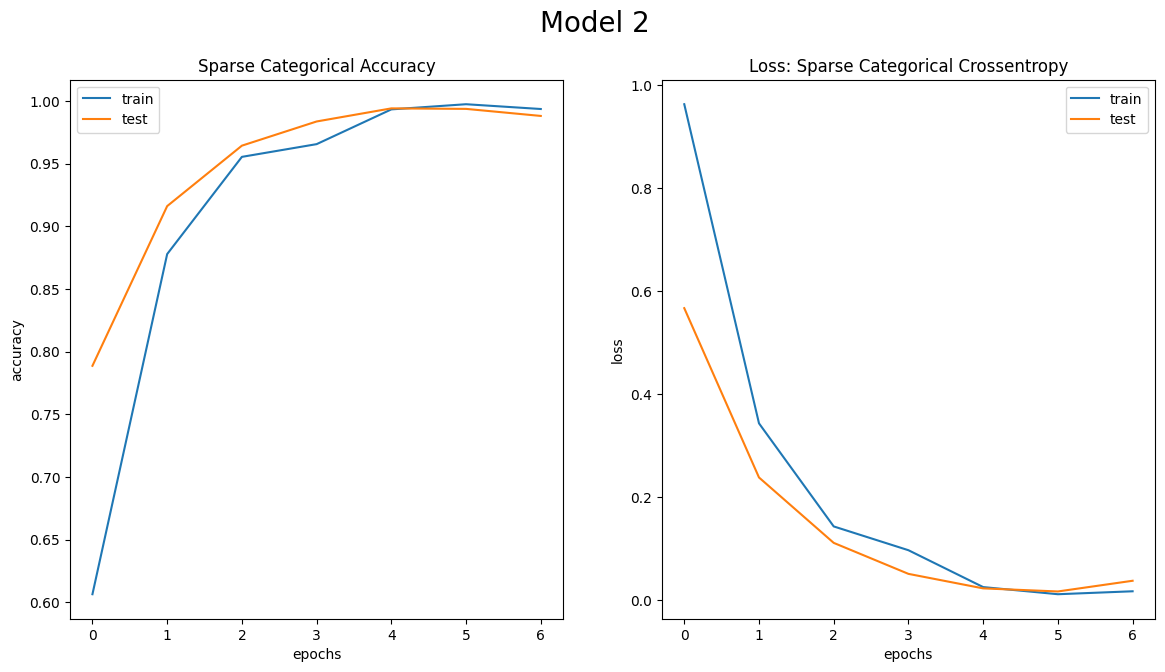

In [65]:
# how did the training process go?
fig, axes = plt.subplots(1,2, figsize=(14,7))

fig.suptitle('Model 2', fontsize = 20)
ax = axes[0]
ax.plot(history_2.history['sparse_categorical_accuracy'], label='train')
ax.plot(history_2.history['val_sparse_categorical_accuracy'], label='test')

ax.set_title('Sparse Categorical Accuracy')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')
ax.legend()

ax = axes[1]
ax.plot(history_2.history['loss'], label='train')
ax.plot(history_2.history['val_loss'], label='test')
ax.set_title('Loss: Sparse Categorical Crossentropy')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend();

plt.savefig('../images/model2.jpg')

In [68]:
mod2 = keras.models.load_model('model_2_checkpoints/01.keras')

In [69]:
preds2 = mod2.predict(val_df)

20/20 ━━━━━━━━━━━━━━━━━━━━ 93s 5s/step


In [70]:
val_y_pred2 = np.argmax(preds2, axis=1)

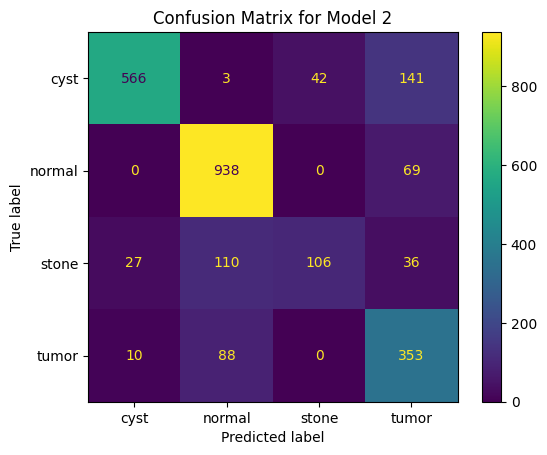

In [77]:
fig, ax = plt.subplots()

ConfusionMatrixDisplay.from_predictions(val_y_true, val_y_pred2, display_labels=['cyst', 'normal', 'stone', 'tumor'], ax=ax);
ax.set_title('Confusion Matrix for Model 2')

fig.savefig('../images/confusionmatrix_model2.png')

In [49]:
report_scores(val_y_true, val_y_pred2, 'Model 2')

Model 2

Accuracy score: 0.7886701486540779

Classification report:
              precision    recall  f1-score   support

        cyst      0.939     0.753     0.835       752
      normal      0.824     0.931     0.874      1007
       stone      0.716     0.380     0.496       279
       tumor      0.589     0.783     0.672       451

    accuracy                          0.789      2489
   macro avg      0.767     0.712     0.720      2489
weighted avg      0.804     0.789     0.784      2489



## Model 3: Adding Dropout layers

In [68]:
model3 = keras.Sequential(
    [
        keras.Input(shape=(1250, 1250, 1)),
        layers.Rescaling(1.0 / 255),
        layers.Conv2D(32,5, strides=2, activation='relu'),
        layers.Conv2D(32,3, activation='relu'),
        layers.MaxPooling2D(3), # output shape was (415, 415, 32) keep downsampling
        layers.Conv2D(32,3, activation='relu'),
        layers.MaxPooling2D(3),
        layers.Conv2D(32,3, activation='relu'),
        layers.MaxPooling2D(3),
        layers.Conv2D(32,3, activation='relu'),
        layers.MaxPooling2D(5),
        layers.GlobalMaxPooling2D(),
        layers.Dense(32),
        layers.Dropout(rate=0.2),
        layers.Dense(16),
        layers.Dropout(rate=0.2),
        layers.Dense(8),
        layers.Dense(4),
        layers.Softmax()
    ]
)

In [69]:
model3.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 1250, 1250, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 623, 623, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 621, 621, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 207, 207, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 205, 205, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 68, 68, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 66, 66, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 20, 20, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_6          │ (None, 32)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_6 (Softmax)             │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,580 (154.61 KB)

 Trainable params: 39,580 (154.61 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
model3.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001), # default learning_rate value
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)

In [74]:
# to make sure I have a back up of the best model so far, just in case of crashes and such.
model3_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = 'model_3_checkpoints/{epoch:02d}.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='max'
)

model3_earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience= 2,
    baseline=0.01,
    start_from_epoch=4
)

In [ ]:
history_3 = model3.fit(
    train_df,
    epochs = 20,
    validation_data = val_df,
    callbacks= [model3_checkpoint, model3_earlystopping]
)

Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2135s 27s/step - loss: 1.2760 - sparse_categorical_accuracy: 0.4184 - val_loss: 0.7245 - val_sparse_categorical_accuracy: 0.7417
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2318s 30s/step - loss: 0.6074 - sparse_categorical_accuracy: 0.7744 - val_loss: 0.2161 - val_sparse_categorical_accuracy: 0.9289
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2263s 29s/step - loss: 0.2253 - sparse_categorical_accuracy: 0.9132 - val_loss: 0.0826 - val_sparse_categorical_accuracy: 0.9715
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2060s 26s/step - loss: 0.1355 - sparse_categorical_accuracy: 0.9502 - val_loss: 0.0407 - val_sparse_categorical_accuracy: 0.9859
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2032s 26s/step - loss: 0.0693 - sparse_categorical_accuracy: 0.9756 - val_loss: 0.0362 - val_sparse_categorical_accuracy: 0.9855
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1994s 26s/step - loss: 0.0542 - sparse_categorical_accuracy: 0.9809 - val_loss: 0.0135 - val_sparse_categorical_accuracy: 0.997

Partway through epoch 8 (around 3 pm, Thursday), I lost power due to a local storm (lost power several times in a row).  Since this model was nearly done with its training loops (high validation accuracy), I'm going to salvage this and run model 4 since there's only time to run 1 more set of training loops.

In [90]:
history3 = pd.DataFrame([
    {'epoch': 1, 'loss': 1.2760, 'sparse_categorical_accuracy': 0.4184, 'val_loss': 0.7245, 'val_sparse_categorical_accuracy': 0.7417},
    {'epoch': 2, 'loss': 0.6074, 'sparse_categorical_accuracy': 0.7744, 'val_loss': 0.2161, 'val_sparse_categorical_accuracy': 0.9289},
    {'epoch': 3, 'loss': 0.2253, 'sparse_categorical_accuracy': 0.9132, 'val_loss': 0.0826, 'val_sparse_categorical_accuracy': 0.9715},
    {'epoch': 4, 'loss': 0.1355, 'sparse_categorical_accuracy': 0.9502, 'val_loss': 0.0407, 'val_sparse_categorical_accuracy': 0.9859},
    {'epoch': 5, 'loss': 0.0693, 'sparse_categorical_accuracy': 0.9756, 'val_loss': 0.0362, 'val_sparse_categorical_accuracy': 0.9855},
    {'epoch': 6, 'loss': 0.0542, 'sparse_categorical_accuracy': 0.9809, 'val_loss': 0.0135, 'val_sparse_categorical_accuracy': 0.9976},
    {'epoch': 7, 'loss': 0.0475, 'sparse_categorical_accuracy': 0.9822, 'val_loss': 0.0129, 'val_sparse_categorical_accuracy': 0.9952},
    {'epoch': 8, 'loss': 0.0152, 'sparse_categorical_accuracy': 0.9948}
])

In [91]:
history3['epoch']

0    1
1    2
2    3
3    4
4    5
5    6
6    7
7    8
Name: epoch, dtype: int64

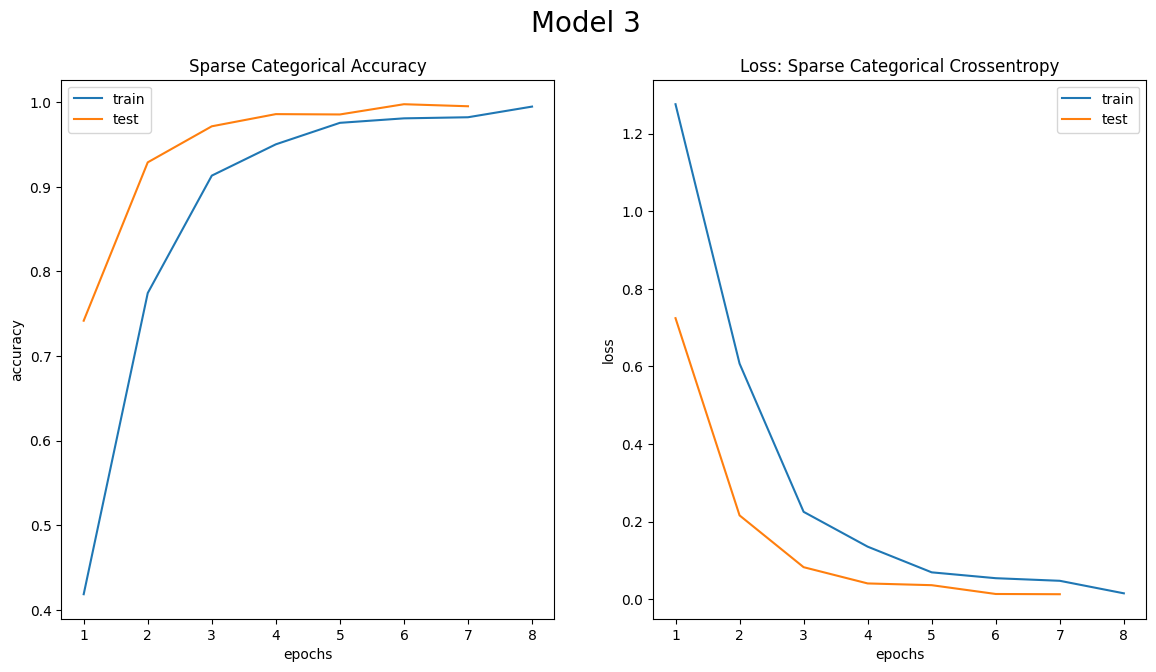

In [92]:
# how did the training process go?
fig, axes = plt.subplots(1,2, figsize=(14,7))

fig.suptitle('Model 3', fontsize = 20)
ax = axes[0]
ax.plot(history3['epoch'], history3['sparse_categorical_accuracy'], label='train')
ax.plot(history3['epoch'], history3['val_sparse_categorical_accuracy'], label='test')

ax.set_title('Sparse Categorical Accuracy')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')
ax.legend()

ax = axes[1]
ax.plot(history3['epoch'], history3['loss'], label='train')
ax.plot(history3['epoch'], history3['val_loss'], label='test')
ax.set_title('Loss: Sparse Categorical Crossentropy')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend();

plt.savefig('../images/model3.jpg')

### Confusion Matrix

In [93]:
mod3 = keras.models.load_model('model_3_checkpoints/01.keras')

In [94]:
preds3 = mod3.predict(val_df)

20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step


In [95]:
val_y_pred3 = np.argmax(preds3, axis=1)

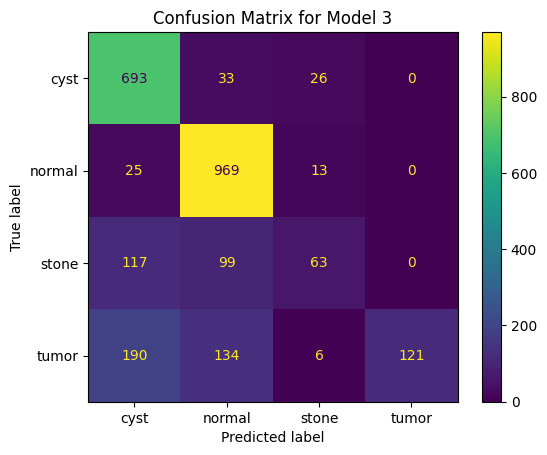

In [96]:
fig, ax = plt.subplots()

ConfusionMatrixDisplay.from_predictions(val_y_true, val_y_pred3, display_labels=['cyst', 'normal', 'stone', 'tumor'], ax=ax);
ax.set_title('Confusion Matrix for Model 3')

fig.savefig('../images/confusionmatrix_model3.png')

In [50]:
report_scores(val_y_true, val_y_pred3, 'Model 3')

Model 3

Accuracy score: 0.7416633186018481

Classification report:
              precision    recall  f1-score   support

        cyst      0.676     0.922     0.780       752
      normal      0.785     0.962     0.864      1007
       stone      0.583     0.226     0.326       279
       tumor      1.000     0.268     0.423       451

    accuracy                          0.742      2489
   macro avg      0.761     0.594     0.598      2489
weighted avg      0.768     0.742     0.699      2489



## Model 4: Learning Rate Schedule

There is only time to run one more model!  I'm going to run this one with a variable learning rate.  No dropout layers to make it easier to compare with model 1.

In [103]:
model4 = keras.Sequential(
    [
        keras.Input(shape=(1250, 1250, 1)),
        layers.Rescaling(1.0 / 255),
        layers.Conv2D(32,5, strides=2, activation='relu'),
        layers.Conv2D(32,3, activation='relu'),
        layers.MaxPooling2D(3), # output shape was (415, 415, 32) keep downsampling
        layers.Conv2D(32,3, activation='relu'),
        layers.MaxPooling2D(3),
        layers.Conv2D(32,3, activation='relu'),
        layers.MaxPooling2D(3),
        layers.Conv2D(32,3, activation='relu'),
        layers.MaxPooling2D(5),
        layers.GlobalMaxPooling2D(),
        layers.Dense(10),
        layers.Dense(4),
        layers.Softmax()
    ]
)

In [104]:
model4.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 1250, 1250, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 623, 623, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 621, 621, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 207, 207, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 205, 205, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 68, 68, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 66, 66, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 20, 20, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_2          │ (None, 32)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │            44 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_2 (Softmax)             │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,198 (149.21 KB)

 Trainable params: 38,198 (149.21 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.01,
    decay_steps = 10000,
    decay_rate = 0.9
)

In [106]:
model4.compile(
    optimizer = keras.optimizers.Adam(learning_rate= lr_schedule),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)

In [107]:
# to make sure I have a back up of the best model so far, just in case of crashes and such.
model4_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = 'model_4_checkpoints/{epoch:02d}.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='max'
)

model4_earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience= 2,
    baseline=0.01,
    start_from_epoch=4
)

In [108]:
history_4 = model4.fit(
    train_df,
    epochs = 20,
    validation_data = val_df,
    callbacks= [model4_checkpoint, model4_earlystopping]
)

Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1639s 21s/step - loss: 1.3099 - sparse_categorical_accuracy: 0.3939 - val_loss: 1.2552 - val_sparse_categorical_accuracy: 0.4066
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1645s 21s/step - loss: 1.0747 - sparse_categorical_accuracy: 0.5909 - val_loss: 0.8704 - val_sparse_categorical_accuracy: 0.6802
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1492s 19s/step - loss: 0.8365 - sparse_categorical_accuracy: 0.6865 - val_loss: 0.7645 - val_sparse_categorical_accuracy: 0.6947
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1432s 18s/step - loss: 0.6993 - sparse_categorical_accuracy: 0.7244 - val_loss: 0.6247 - val_sparse_categorical_accuracy: 0.7618
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1435s 18s/step - loss: 0.6195 - sparse_categorical_accuracy: 0.7536 - val_loss: 0.5273 - val_sparse_categorical_accuracy: 0.8035
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1613s 21s/step - loss: 0.5319 - sparse_categorical_accuracy: 0.7810 - val_loss: 0.4821 - val_sparse_categorical_accuracy: 0.822

In [109]:
model4.save('model4.keras')

In [110]:
history_4.history['sparse_categorical_accuracy']

[0.4012252688407898,
 0.6250878572463989,
 0.6879582405090332,
 0.7246158719062805,
 0.7537410855293274,
 0.7828662991523743,
 0.8491513729095459,
 0.8644170165061951,
 0.8963543176651001,
 0.9045897126197815]

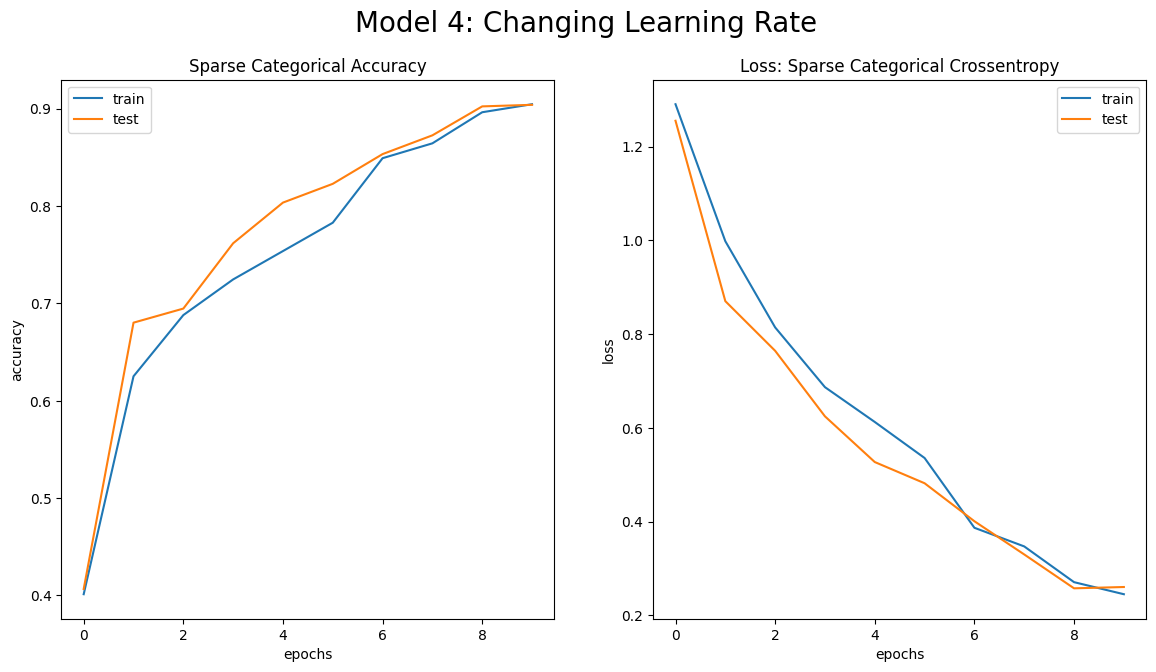

In [111]:
# how did the training process go?
fig, axes = plt.subplots(1,2, figsize=(14,7))

fig.suptitle('Model 4: Changing Learning Rate', fontsize = 20)
ax = axes[0]
ax.plot(history_4.history['sparse_categorical_accuracy'], label='train')
ax.plot(history_4.history['val_sparse_categorical_accuracy'], label='test')

ax.set_title('Sparse Categorical Accuracy')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')
ax.legend()

ax = axes[1]
ax.plot(history_4.history['loss'], label='train')
ax.plot(history_4.history['val_loss'], label='test')
ax.set_title('Loss: Sparse Categorical Crossentropy')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend();

plt.savefig('../images/model4.jpg')

In [93]:
# mod4 = keras.models.load_model('model_4_checkpoints/01.keras')

In [113]:
preds4 = model4.predict(val_df)

20/20 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step


In [114]:
val_y_pred4 = np.argmax(preds4, axis=1)

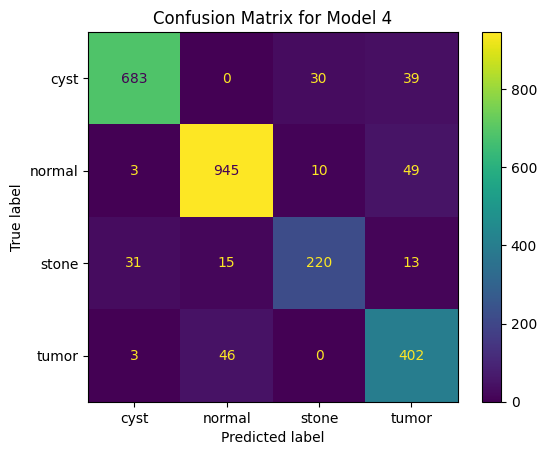

In [115]:
fig, ax = plt.subplots()

ConfusionMatrixDisplay.from_predictions(val_y_true, val_y_pred4, display_labels=['cyst', 'normal', 'stone', 'tumor'], ax=ax);
ax.set_title('Confusion Matrix for Model 4')

fig.savefig('../images/confusionmatrix_model4.png')

In [121]:
report_scores(val_y_true, val_y_pred4, 'Model 4')

Model 4

Classification report:
              precision    recall  f1-score   support

        cyst      0.949     0.908     0.928       752
      normal      0.939     0.938     0.939      1007
       stone      0.846     0.789     0.816       279
       tumor      0.799     0.891     0.843       451

    accuracy                          0.904      2489
   macro avg      0.883     0.882     0.881      2489
weighted avg      0.906     0.904     0.904      2489



## Conclusions

**Always back up your work frequently!!**

Using the weighted averages for the precision, recall, and F1-score.

| Model     | Model 1  | Model 2     | Model 3  | Model 4                |
| --- | --- | --- | --- | --- |
| Summary   | Base     | More layers | Dropouts | Variable learning rate |
| Accuracy  | $88.6\%$ | $78.9\%$    | $74.2\%$ | $90.4\%$                   |
| Precision | $90.4\%$ | $80.4\%$    | $76.8\%$ | $90.6\%$                   |
| Recall    | $88.6\%$ | $78.9\%$    | $74.2\%$ | $90.4\%$                   |
| F1-score  | $88.6\%$ | $78.4\%$    | $69.9\%$ | $90.4\%$                   |

Model 4 performed the best overall, although model 1 also did surprisingly well.  I think this is because the most powerful part of the model are the convolution blocks and those I did not touch after I got the first model working.  I wish I had more time to play around with those.  

At this point, I would not implement any of these model as they can not identify any condition with a degree of confidence.  However, this is at a very early stage of exploration and many others have explored this parameter-space more thoroughly than I have.  With more fine-tuning, building on pre-trained models, and further research, improvements are likely.